# Transmission

In [1]:
import astropy.constants as const
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pymc as pm
# our custom plot style
from matplotlib_stylesheet import group05_style_sheet, style_rest, set_size
#plt.rcParams.update(group05_style_sheet)
from transmission_functions import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Plot Opacities over Temperature

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_40924/1392666422.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Wavelength ($\mu$m)', fontsize =28)


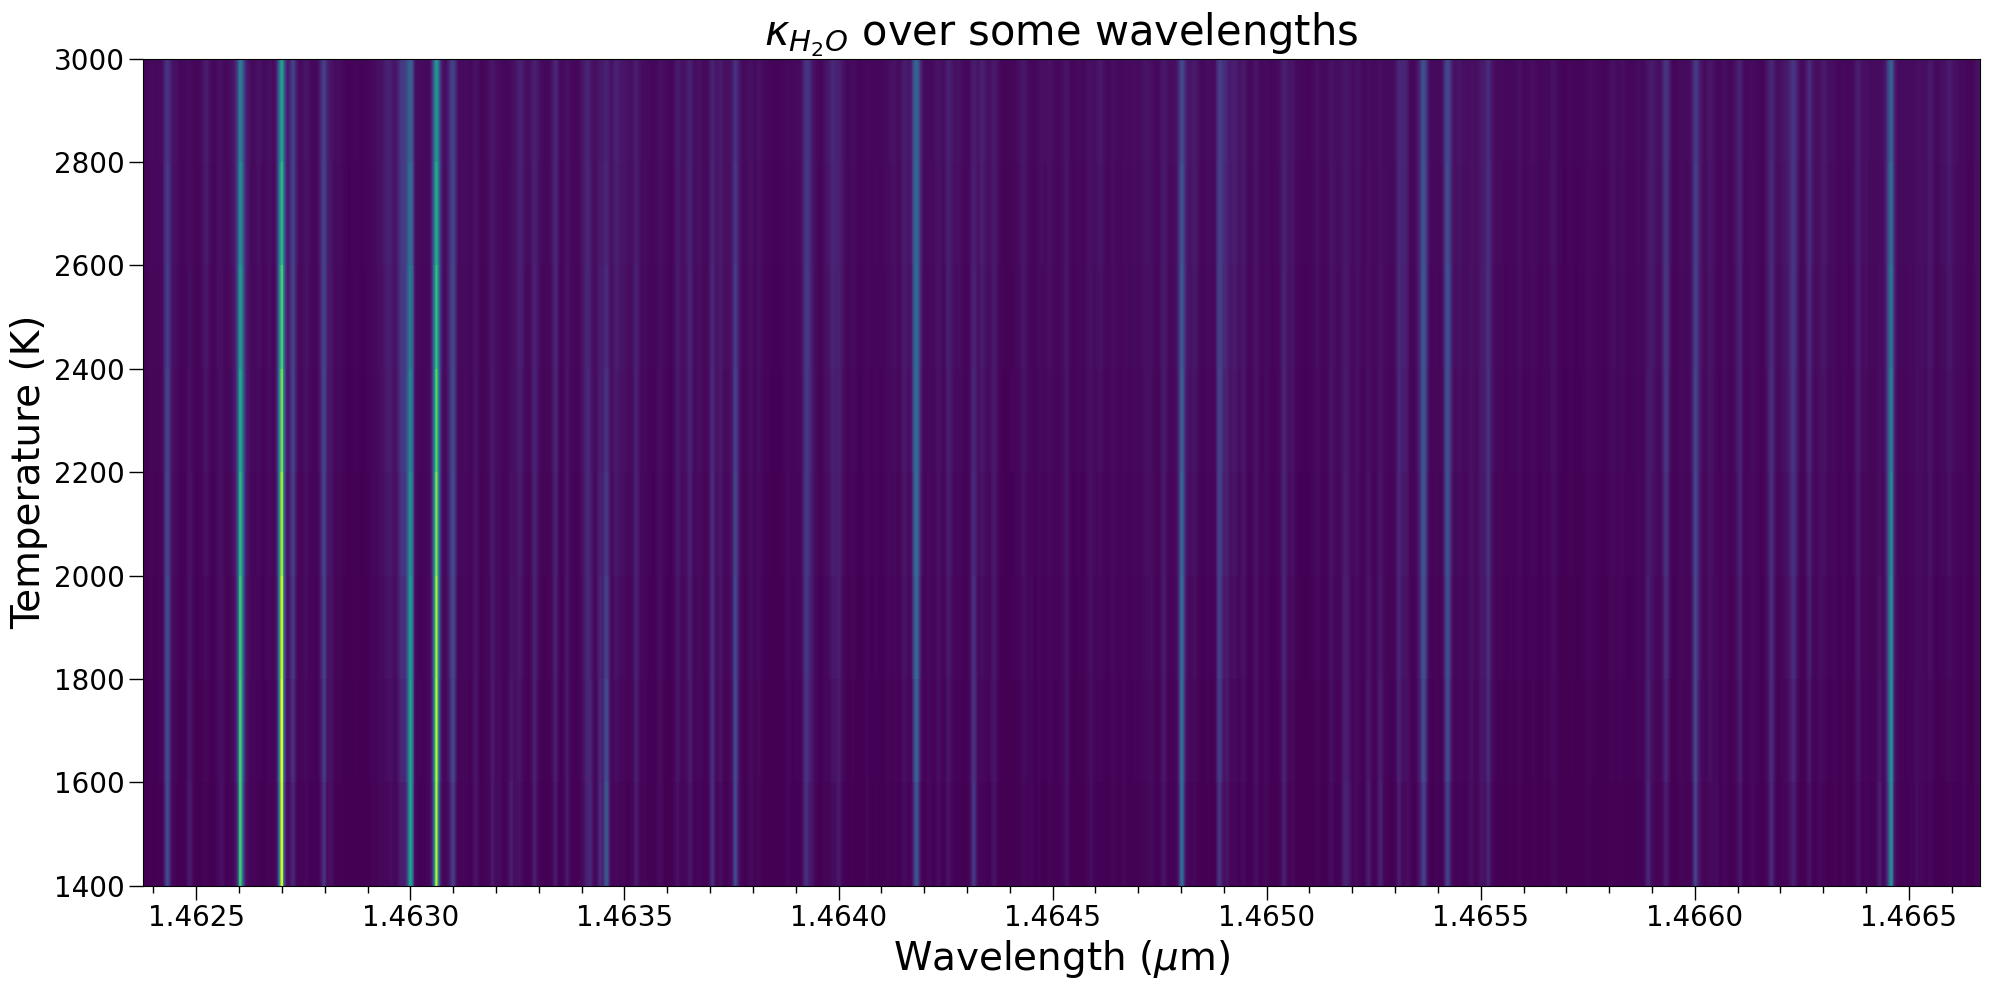

In [2]:
waves, opacities, temperatures = read_opacity_data(molecule="H2O")

fig, ax = plt.subplots(figsize =(20 ,10))

plt.pcolormesh(
    waves[-502000:-500000], 
    temperatures, 
    opacities[:, -502000:-500000], 
    shading='nearest', 
    cmap='viridis'
)
# plt.pcolormesh(wl[-600000:-400000], T_axis, K_H2O[:, -600000:-400000], shading='nearest', cmap='viridis')
# plt.pcolormesh(wl, T_axis, K_H2O, shading='nearest', cmap='viridis')

ax.set_xlabel('Wavelength ($\mu$m)', fontsize =28)
ax.set_ylabel('Temperature (K)', fontsize =28)
ax.set_title(r'$\kappa_{H_2O}$ over some wavelengths', fontsize=30)

ax = plt.gca()
ax.ticklabel_format(useOffset=False)

for axx in [ax]:
    axx.xaxis.set_tick_params(labelsize =20)
    axx.yaxis.set_tick_params(labelsize =20)
    axx.xaxis.set_minor_locator(AutoMinorLocator(5))
    axx.tick_params('both', length=10, width=1, which='major')
    axx.tick_params('both', length=5, width=1, which='minor')


plt.tight_layout()
plt.savefig('opacities2D.png')

In [4]:
# styling

font_factor = 10.88 / 12

main_font_size = 12 * font_factor
axes_font_size = 10 * font_factor

group05_style_sheet = {
    # for the font, the NotoSansMath-Regular_v3.ttf has to be in the same
    # folder)
    'font.family': 'Noto Sans Math',
    'font.size': main_font_size,
    'axes.titlesize': main_font_size + 3,
    'axes.labelsize': main_font_size,
    'axes.grid': True,
    'axes.grid.which': 'major',
    'grid.color': '#F5F5F5', # == lightest LMU grey
    'grid.linewidth': 1,
    'grid.linestyle': '-',
    'xtick.direction': 'in',
    'xtick.top': True,
    'xtick.minor.visible': True,
    'xtick.labelsize': axes_font_size,
    'ytick.direction': 'in',
    'ytick.right': True,
    'ytick.minor.visible': True,
    'ytick.labelsize': axes_font_size,
    'axes.prop_cycle': plt.cycler('color', ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']),
    'figure.dpi': 140,
     # width is \textwidth in our latex file, height is from golden ratio
    'figure.figsize': (5.5118119551681195, 3.4064871278919098),
    'legend.fontsize': axes_font_size,
    'legend.frameon': False,
    'legend.framealpha': 1, # makes background of legend transparent
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0,
}
plt.rcParams.update(group05_style_sheet)


## Rebinning the Opacity

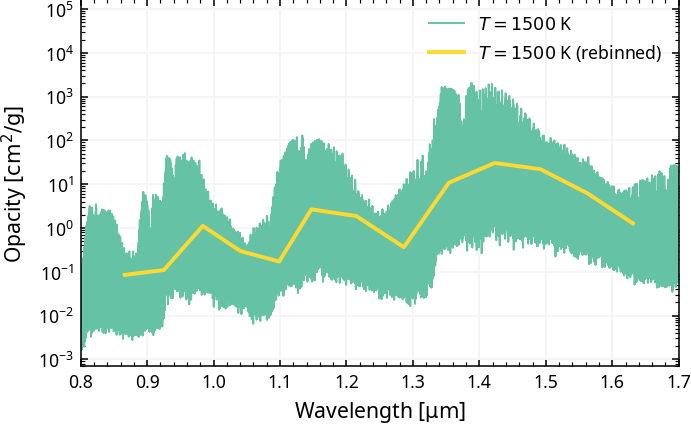

In [5]:
fig, ax = plt.subplots()

waves, contrast, contrast_err = read_observation_data(study="krenberg")
waves_k_h2o, k_h2o = give_opacity(new_temperature=1500, molecule="H2O")
k_h2o_reb = rebin_opacity(opacity=k_h2o, waves_old=waves_k_h2o,
                          waves_target=waves)
waves_new, k_new, _ = read_opacity_data(molecule="H2O")

ax.plot(waves_new, k_new[0], linewidth=1, linestyle="-", marker="",
        label=r"$T = 1500$ K", zorder=1.9)
ax.plot(waves, k_h2o_reb, linewidth=2, linestyle="-", marker="",
        color="#ffd92f", label=r"$T = 1500$ K (rebinned)")
ax.set_yscale("log")
ax.set_xlim(0.8,1.7)
ax.legend()
ax.set_xlabel(r"Wavelength [$\mathrm{\mu m}$]")
ax.set_ylabel(r"Opacity [$\mathrm{cm^2/g}$]")

plt.savefig("./figures/transmission_rebinning.svg")
plt.show()


## WASP-12b "Fit"

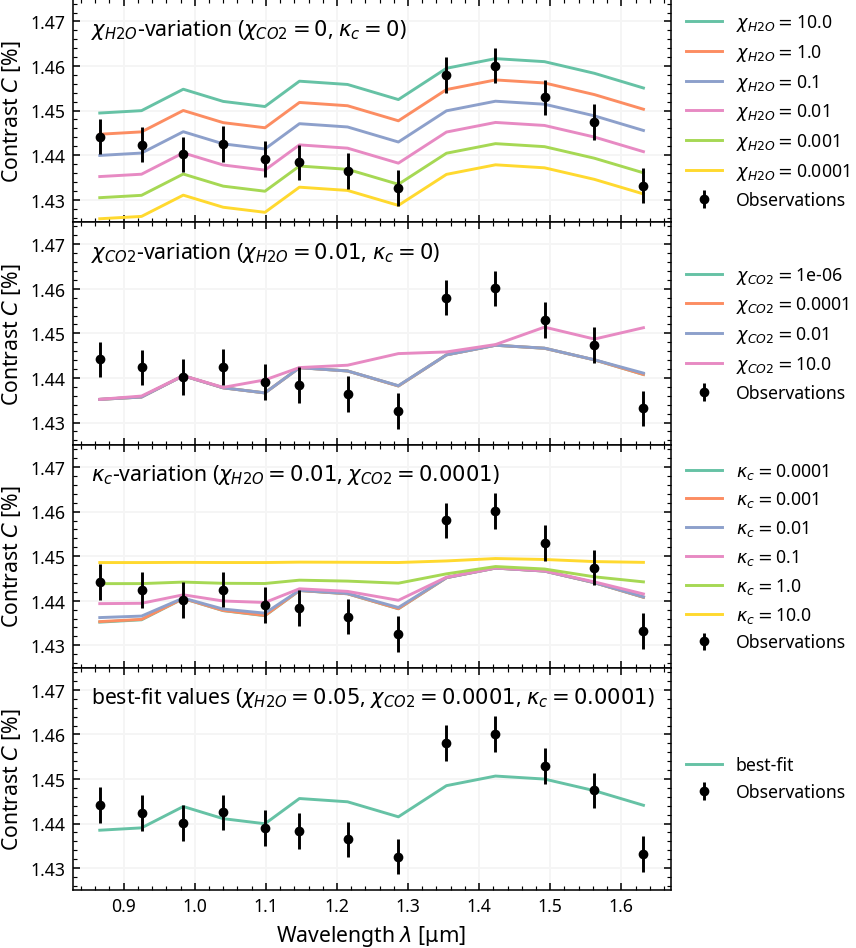

In [6]:
# all our constants for WASP-12b and the molecular masses
R_0_wasp = 1.9 * const.R_jup
g_wasp = 43.67 * u.m / u.s**2
R_star_wasp = 1.64 * const.R_sun
T_wasp = 1200 * u.K
P_0_wasp = 10 * u.bar
mu_wasp = 2.33
P_wasp = 1.09 * u.d
gamma = 0.57721
m_h2o = 18.02
m_co2 = 44.01

# the observation data that we fit to
waves, contrast, contrast_err = read_observation_data(study="krenberg")

# getting h2o opacity comparison values
waves_k_h2o, k_h2o = give_opacity(new_temperature=T_wasp.value, molecule="H2O")
# rebinning the opacities to fit the observation data
k_h2o_reb = rebin_opacity(opacity=k_h2o, waves_old=waves_k_h2o,
                          waves_target=waves)

# getting co2 opacity comparison values
waves_k_co2, k_co2 = give_opacity(new_temperature=T_wasp.value, molecule="CO2")
# rebinning the opacities to fit the observation data
k_co2_reb = rebin_opacity(opacity=k_co2, waves_old=waves_k_co2,
                          waves_target=waves)

def get_k_tot(chi_h2o, chi_co2, kappa_c):
    k_tot = (m_h2o * chi_h2o * k_h2o_reb
         + m_co2 * chi_co2 * k_co2_reb
         + kappa_c) * u.cm**2 / u.g
    return k_tot

def get_k_tot_unbinned(chi_h2o, chi_co2, kappa_c):
    k_tot_unbinned = (m_h2o * chi_h2o * k_h2o
         + m_co2 * chi_co2 * k_co2
         + kappa_c) * u.cm**2 / u.g
    return k_tot_unbinned

def model_contrast_wasp(k_tot):
    cont = calculate_contrast(
    k_tot=k_tot, gamma=gamma, R_0=R_0_wasp,
    T=T_wasp, mu=mu_wasp, g=g_wasp, P_0=P_0_wasp,
    R_star=R_star_wasp)
    return cont

font_factor = 10.88 / 12

main_font_size = 12 * font_factor
axes_font_size = 10 * font_factor

group05_style_sheet = {
    # for the font, the NotoSansMath-Regular_v3.ttf has to be in the same
    # folder)
    'font.family': 'Noto Sans Math',
    'font.size': main_font_size,
    'axes.titlesize': main_font_size + 3,
    'axes.labelsize': main_font_size,
    'axes.grid': True,
    'axes.grid.which': 'major',
    'grid.color': '#F5F5F5', # == lightest LMU grey
    'grid.linewidth': 1,
    'grid.linestyle': '-',
    'xtick.direction': 'in',
    'xtick.top': True,
    'xtick.minor.visible': True,
    'xtick.labelsize': axes_font_size,
    'ytick.direction': 'in',
    'ytick.right': True,
    'ytick.minor.visible': True,
    'ytick.labelsize': axes_font_size,
    'axes.prop_cycle': plt.cycler('color', ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']),
    'figure.dpi': 140,
     # width is \textwidth in our latex file, height is from golden ratio
    'figure.figsize': (5.5118119551681195, 3.4064871278919098),
    'legend.fontsize': axes_font_size,
    'legend.frameon': False,
    'legend.framealpha': 1, # makes background of legend transparent
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0,
}

plt.rcParams.update(group05_style_sheet)

fig, axs = plt.subplots(nrows=4, sharex="col",
                        figsize=set_size(height_factor=1.5))
plt.subplots_adjust(wspace=0, hspace=0)

axs = axs.flat

# varying chi h2o
chi_h2o_var = np.geomspace(1e-4,1e1,6)[::-1]
for chi_water in chi_h2o_var:
    curr_k_tot = get_k_tot(chi_h2o=chi_water, chi_co2=0, kappa_c=0)
    curr_contr = model_contrast_wasp(curr_k_tot)
    axs[0].plot(waves, curr_contr, label=fr"$\chi_{{H2O}} =${chi_water}")

# varying chi co2
chi_co2_var = [1e-6,1e-4,1e-2,1e1]
for chi_carbdio in chi_co2_var:
    curr_k_tot = get_k_tot(chi_h2o=1e-2, chi_co2=chi_carbdio, kappa_c=0)
    curr_contr = model_contrast_wasp(curr_k_tot)
    axs[1].plot(waves, curr_contr, label=fr"$\chi_{{CO2}} =${chi_carbdio}")

# varying kappa_c
kappa_c_var = np.geomspace(1e-4,1e1,6)
for curr_kappa in kappa_c_var:
    curr_k_tot = get_k_tot(chi_h2o=1e-2, chi_co2=1e-4, kappa_c=curr_kappa)
    curr_contr = model_contrast_wasp(curr_k_tot)
    axs[2].plot(waves, curr_contr, label=fr"$\kappa_{{c}} =${curr_kappa}")

# plotting the best-fit
curr_k_tot = get_k_tot(chi_h2o=5e-2, chi_co2=1e-4, kappa_c=1e-4)
curr_contr = model_contrast_wasp(curr_k_tot)
axs[3].plot(waves, curr_contr, label=fr"best-fit")

for ax in axs:
    ax.grid(visible=True, which="major", color="#F5F5F5")
    ax.label_outer()
    ax.errorbar(waves, contrast, contrast_err, linestyle="", marker="o",
                color="black", label="Observations", markersize=4)
    ax.set_ylim(1.425,1.475)
    ax.legend(loc="center left", bbox_to_anchor=(1,0.5))
    ax.set_xlabel(r"Wavelength $\lambda$ [$\mathrm{\mu m}$]")
    ax.set_ylabel(r"Contrast $C$ [%]")

axs[0].text(0.03, 0.92,
            r"$\chi_{H2O}$-variation ($\chi_{CO2}=0$, $\kappa_c=0$)",
            transform=axs[0].transAxes, ha="left", va="top")
axs[1].text(0.03, 0.92,
            r"$\chi_{CO2}$-variation ($\chi_{H2O}=0.01$, $\kappa_c=0$)",
            transform=axs[1].transAxes, ha="left", va="top")
axs[2].text(0.03, 0.92,
            r"$\kappa_c$-variation ($\chi_{H2O}=0.01$, $\chi_{CO2}=0.0001$)",
            transform=axs[2].transAxes, ha="left", va="top")
axs[3].text(0.03, 0.92,
            (r"best-fit values ($\chi_{H2O}=0.05$, "
             + r"$\chi_{CO2}=0.0001$, $\kappa_c=0.0001$)"),
            transform=axs[3].transAxes, ha="left", va="top")

plt.savefig("./figures/contrast_wasp.svg")
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 2 jobs)
NUTS: [chi_h2o, chi_co2, kappa_c]


Output()

Sampling 10 chains for 1_000 tune and 2_000 draw iterations (10_000 + 20_000 draws total) took 104 seconds.


array([<Axes: title={'center': 'chi_h2o'}>,
       <Axes: title={'center': 'chi_co2'}>,
       <Axes: title={'center': 'kappa_c'}>], dtype=object)

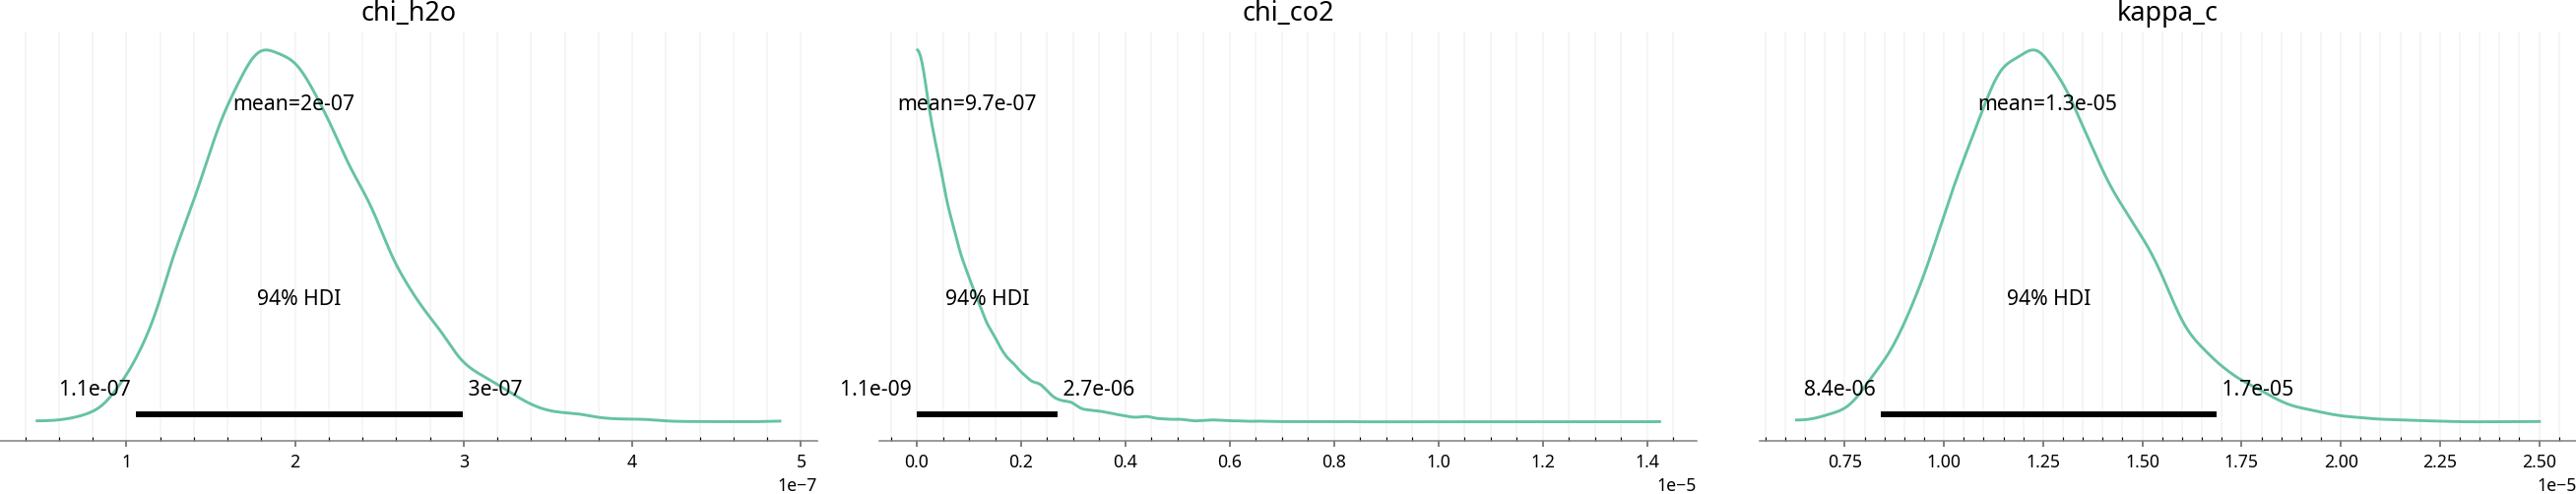

In [45]:
with pm.Model() as model:
    chi_h2o = pm.Uniform("chi_h2o", lower=1e-9, upper=1e-4)
    chi_co2 = pm.Uniform("chi_co2", lower=1e-9, upper=1e-4)
    kappa_c = pm.Uniform("kappa_c", lower=1e-9, upper=1e-4)

    k_tot_model = (m_h2o * chi_h2o * k_h2o_reb
                   + m_co2 * chi_co2 * k_co2_reb
                   + kappa_c)

    model_contrast = calculate_contrast2(
        k_tot=k_tot_model, gamma=gamma, R_0=R_0.value,
        T=T.si.value, mu=mu, g=g.si.value, P_0=P_0.si.value,
        R_star=R_star.si.value)

    likelihood = pm.Normal("likelihood", mu=model_contrast, sigma=contrast_err, observed=contrast)

    trace = pm.sample(draws=2000, tune=1000, target_accept=0.9, chains=10)

pm.summary(trace)
pm.plot_posterior(trace, var_names=["chi_h2o", "chi_co2", "kappa_c"])


In [9]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
chi_h2o,0.0,0.0,0.0,0.0,0.0,0.0,12607.0,10905.0,1.0
chi_co2,0.0,0.0,0.0,0.0,0.0,0.0,10793.0,6917.0,1.0
kappa_c,0.0,0.0,0.0,0.0,0.0,0.0,12935.0,13223.0,1.0


## HD209458b "Fit"

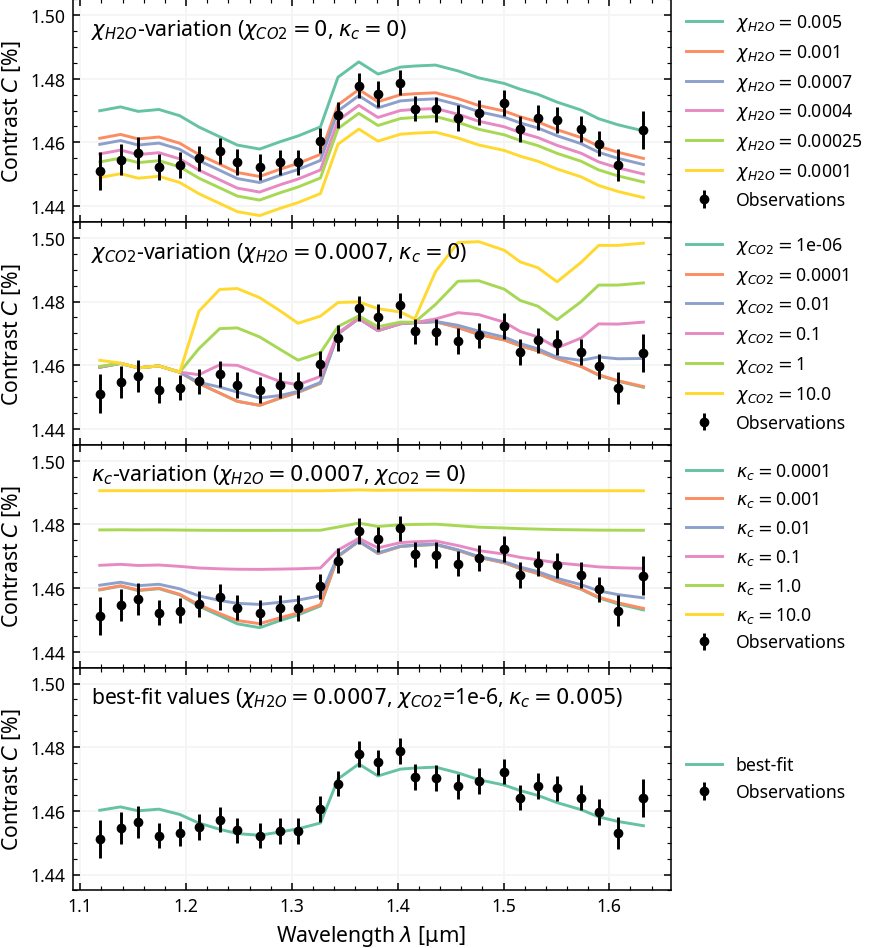

In [7]:
# all our constants for hd-12b and the molecular masses
R_0_hd = 1.39 * const.R_jup
g_hd =  28.8 * u.m / u.s**2
R_star_hd = 1.203 * const.R_sun
T_hd = 1500 * u.K
P_0_hd = 10 * u.bar
mu_hd = 2.33
P_hd = 3.52 * u.d
gamma = 0.57721
m_h2o = (18.02)
m_co2 = (44.01)

# the observation data that we fit to
waves, contrast, contrast_err = read_observation_data(study="denning")

# getting h2o opacity comparison values
waves_k_h2o, k_h2o = give_opacity(new_temperature=T_hd.value, molecule="H2O")
# rebinning the opacities to fit the observation data
k_h2o_reb = rebin_opacity(opacity=k_h2o, waves_old=waves_k_h2o,
                          waves_target=waves)

# getting co2 opacity comparison values
waves_k_co2, k_co2 = give_opacity(new_temperature=T_hd.value, molecule="CO2")
# rebinning the opacities to fit the observation data
k_co2_reb = rebin_opacity(opacity=k_co2, waves_old=waves_k_co2,
                          waves_target=waves)

def get_k_tot(chi_h2o, chi_co2, kappa_c):
    k_tot = (m_h2o * chi_h2o * k_h2o_reb
         + m_co2 * chi_co2 * k_co2_reb
         + kappa_c) * u.cm**2 / u.g
    return k_tot

def get_k_tot_unbinned(chi_h2o, chi_co2, kappa_c):
    k_tot_unbinned = (m_h2o * chi_h2o * k_h2o
         + m_co2 * chi_co2 * k_co2
         + kappa_c) * u.cm**2 / u.g
    return k_tot_unbinned

def model_contrast_hd(k_tot):
    cont = calculate_contrast(
    k_tot=k_tot, gamma=gamma, R_0=R_0_hd,
    T=T_hd, mu=mu_hd, g=g_hd, P_0=P_0_hd,
    R_star=R_star_hd)
    return cont

font_factor = 10.88 / 12

main_font_size = 12 * font_factor
axes_font_size = 10 * font_factor

group05_style_sheet = {
    # for the font, the NotoSansMath-Regular_v3.ttf has to be in the same
    # folder)
    'font.family': 'Noto Sans Math',
    'font.size': main_font_size,
    'axes.titlesize': main_font_size + 3,
    'axes.labelsize': main_font_size,
    'axes.grid': True,
    'axes.grid.which': 'major',
    'grid.color': '#F5F5F5', # == lightest LMU grey
    'grid.linewidth': 1,
    'grid.linestyle': '-',
    'xtick.direction': 'in',
    'xtick.top': True,
    'xtick.minor.visible': True,
    'xtick.labelsize': axes_font_size,
    'ytick.direction': 'in',
    'ytick.right': True,
    'ytick.minor.visible': True,
    'ytick.labelsize': axes_font_size,
    'axes.prop_cycle': plt.cycler('color', ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']),
    'figure.dpi': 140,
     # width is \textwidth in our latex file, height is from golden ratio
    'figure.figsize': (5.5118119551681195, 3.4064871278919098),
    'legend.fontsize': axes_font_size,
    'legend.frameon': False,
    'legend.framealpha': 1, # makes background of legend transparent
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0,
}

plt.rcParams.update(group05_style_sheet)

fig, axs = plt.subplots(nrows=4, sharex="col",
                        figsize=set_size(height_factor=1.5))
plt.subplots_adjust(wspace=0, hspace=0)

axs = axs.flat

# varying chi h2o
chi_h2o_var = [0.005, 0.001, 0.0007, 0.0004, 0.00025, 0.0001]
for chi_water in chi_h2o_var:
    curr_k_tot = get_k_tot(chi_h2o=chi_water, chi_co2=0, kappa_c=0)
    curr_contr = model_contrast_hd(curr_k_tot)
    axs[0].plot(waves, curr_contr, label=fr"$\chi_{{H2O}} =${chi_water}")

# varying chi co2
chi_co2_var = [1e-6,1e-4,1e-2,1e-1,1,1e1]
for chi_carbdio in chi_co2_var:
    curr_k_tot = get_k_tot(chi_h2o=7e-4, chi_co2=chi_carbdio, kappa_c=0)
    curr_contr = model_contrast_hd(curr_k_tot)
    axs[1].plot(waves, curr_contr, label=fr"$\chi_{{CO2}} =${chi_carbdio}")

# varying kappa_c
kappa_c_var = np.geomspace(1e-4,1e1,6)
for curr_kappa in kappa_c_var:
    curr_k_tot = get_k_tot(chi_h2o=7e-4, chi_co2=1e-6, kappa_c=curr_kappa)
    curr_contr = model_contrast_hd(curr_k_tot)
    axs[2].plot(waves, curr_contr, label=fr"$\kappa_{{c}} =${curr_kappa}")

# plotting the best-fit
curr_k_tot = get_k_tot(chi_h2o=7e-4, chi_co2=1e-6, kappa_c=5e-3)
curr_contr = model_contrast_hd(curr_k_tot)
axs[3].plot(waves, curr_contr, label=fr"best-fit")

for ax in axs:
    ax.grid(visible=True, which="major", color="#F5F5F5")
    ax.label_outer()
    ax.errorbar(waves, contrast, contrast_err, linestyle="", marker="o",
                color="black", label="Observations", markersize=4)
    ax.set_ylim(1.435,1.505)
    ax.legend(loc="center left", bbox_to_anchor=(1,0.5))
    ax.set_xlabel(r"Wavelength $\lambda$ [$\mathrm{\mu m}$]")
    ax.set_ylabel(r"Contrast $C$ [%]")

axs[0].text(0.03, 0.92,
            r"$\chi_{H2O}$-variation ($\chi_{CO2}=0$, $\kappa_c=0$)",
            transform=axs[0].transAxes, ha="left", va="top")
axs[1].text(0.03, 0.92,
            r"$\chi_{CO2}$-variation ($\chi_{H2O}=0.0007$, $\kappa_c=0$)",
            transform=axs[1].transAxes, ha="left", va="top")
axs[2].text(0.03, 0.92,
            r"$\kappa_c$-variation ($\chi_{H2O}=0.0007$, $\chi_{CO2}=0$)",
            transform=axs[2].transAxes, ha="left", va="top")
axs[3].text(0.03, 0.92,
            (r"best-fit values ($\chi_{H2O}=0.0007$, "
             + r"$\chi_{CO2}$=1e-6, $\kappa_c=0.005$)"),
            transform=axs[3].transAxes, ha="left", va="top")

plt.savefig("./figures/contrast_hd.svg")
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 2 jobs)
NUTS: [chi_h2o, chi_co2, kappa_c]


Output()

Sampling 10 chains for 1_000 tune and 2_000 draw iterations (10_000 + 20_000 draws total) took 97 seconds.


array([<Axes: title={'center': 'chi_h2o'}>,
       <Axes: title={'center': 'chi_co2'}>,
       <Axes: title={'center': 'kappa_c'}>], dtype=object)

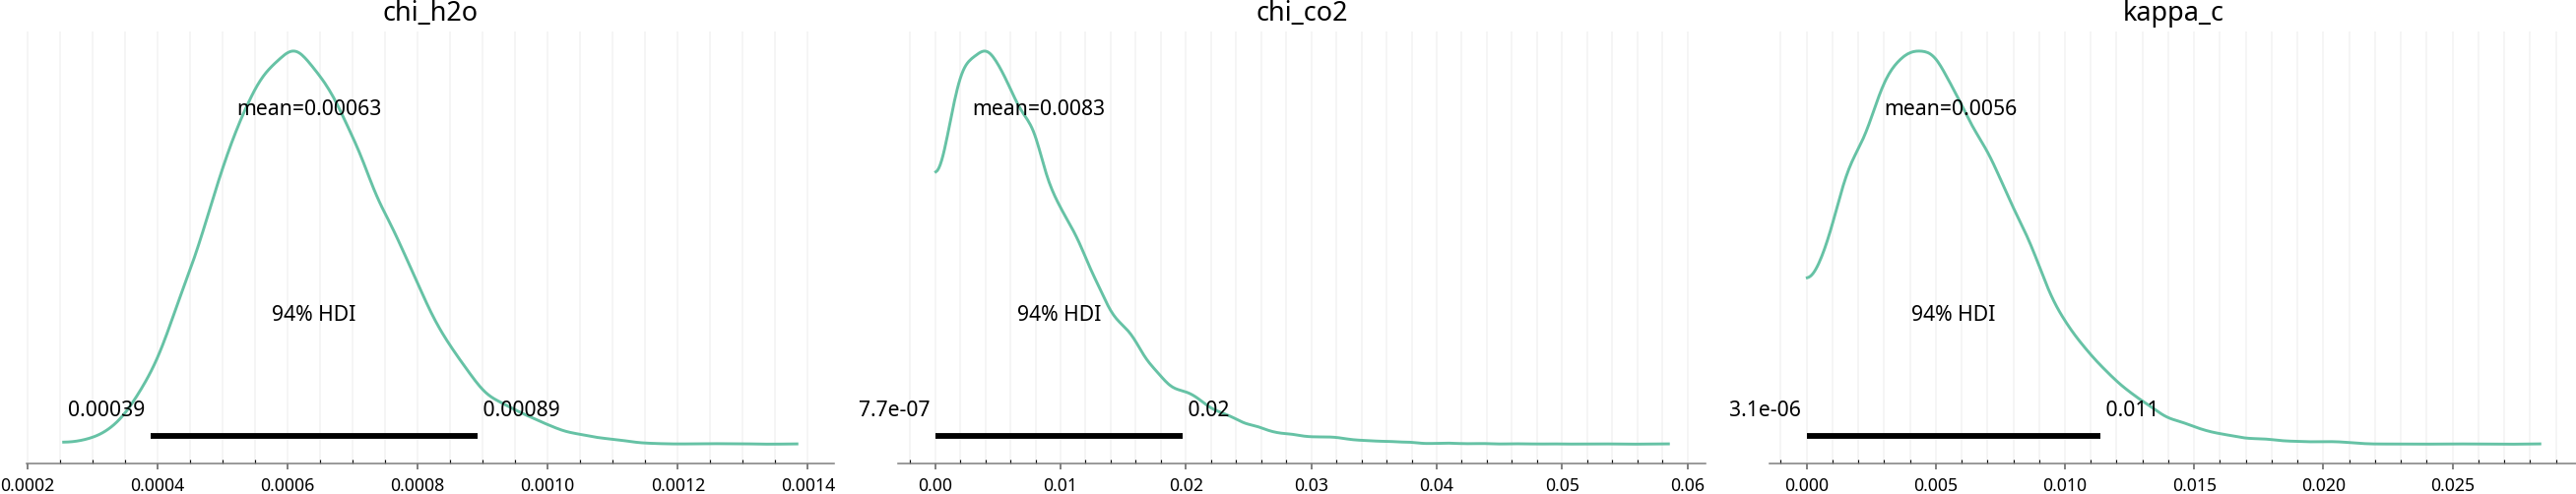

In [20]:
with pm.Model() as model:
    chi_h2o = pm.Uniform("chi_h2o", lower=1e-5, upper=1)
    chi_co2 = pm.Uniform("chi_co2", lower=1e-5, upper=1)
    kappa_c = pm.Uniform("kappa_c", lower=1e-5, upper=1)

    k_tot_model = (m_h2o * chi_h2o * k_h2o_reb
                   + m_co2 * chi_co2 * k_co2_reb
                   + kappa_c)

    model_contrast = calculate_contrast2(
        k_tot=k_tot_model, gamma=gamma, R_0=R_0.value,
        T=T.si.value, mu=mu, g=g.si.value, P_0=P_0.si.value,
        R_star=R_star.si.value)

    likelihood = pm.Normal("likelihood", mu=model_contrast, sigma=contrast_err, observed=contrast)

    trace = pm.sample(draws=2000, tune=1000, target_accept=0.9, chains=10)

pm.summary(trace)
pm.plot_posterior(trace, var_names=["chi_h2o", "chi_co2", "kappa_c"])


In [21]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
chi_h2o,0.001,0.000,0.0,0.001,0.0,0.0,10860.0,9909.0,1.0
chi_co2,0.008,0.006,0.0,0.020,0.0,0.0,9715.0,6783.0,1.0
kappa_c,0.006,0.003,0.0,0.011,0.0,0.0,8817.0,5378.0,1.0
